<a href="https://colab.research.google.com/github/Pedro-Prestes/learning/blob/master/An%C3%A1lise_Explorat%C3%B3ria_de_Dados_de_Log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

A análise exploratória de dados de logística é um processo essencial para entender e extrair insights valiosos a partir dos dados relacionados às operações logísticas de uma empresa. Nesse contexto, os dados podem incluir informações sobre entregas, hubs de distribuição, veículos, rotas, tempos de entrega, entre outros.
O objetivo dessa análise é obter uma compreensão aprofundada do desempenho logístico, identificar padrões e tendências, e gerar insights que possam ser utilizados para otimizar as operações e tomar decisões estratégicas mais informadas. Através da exploração dos dados, é possível identificar gargalos, alocar recursos de forma mais eficiente, melhorar o planejamento de rotas, reduzir custos e aprimorar a satisfação do cliente.

Neste projeto de análise exploratória de dados de logística, utilizamos um conjunto de dados que contém informações sobre as entregas realizadas em diferentes regiões, hubs de distribuição, capacidade dos veículos e localizações geográficas. Através desse conjunto de dados, iremos realizar análises, visualizações e extrair insights para entender melhor o desempenho logístico e identificar possíveis áreas de melhoria.

Vamos prosseguir com a exploração dos dados, realizando análises mais detalhadas e criando visualizações que nos permitam obter insights significativos para aprimorar as operações logísticas.

## 2\. Pacotes e bibliotecas

In [9]:
!pip install pandas
!pip install geopandas
!pip install matplotlib
!pip install seaborn
!pip3 install geopandas;

In [10]:
import json
import os

import pandas as pd
import seaborn as sns

import geopandas as gpd
import matplotlib.pyplot as plt

import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import numpy as np

import geopandas

In [11]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

<ipython-input-11-d867fd071f7d>:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [12]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

In [13]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [14]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

replace ./maps/ASB_Cemiterio_A.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## 3\. Exploração de dados

In [15]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

deliveries_df = pd.DataFrame(data)

hub_origin_df = pd.json_normalize(deliveries_df["origin"])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [16]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [17]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.053411,...,Distrito Federal,BR-DF,Região Centro-Oeste,70330-400,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [18]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

<ipython-input-18-e7ffd1c368d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
<ipython-input-18-e7ffd1c368d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
<ipython-input-18-e7ffd1c368d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [19]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [20]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


In [21]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [22]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [23]:
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

0.26754738276724477

In [24]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

In [25]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
Name: count, dtype: float64

In [26]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
Name: count, dtype: float64

## 4\. Manipulação

In [27]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [28]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [29]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


## 5\. Visualização

1. Distribuição das entregas por região:

A distribuição das entregas está concentrada nos hubs das regiões 1 e 2, enquanto a região 0 possui uma proporção menor de entregas.
Essa concentração pode indicar uma demanda maior nessas regiões ou uma necessidade estratégica de concentrar as operações logísticas.

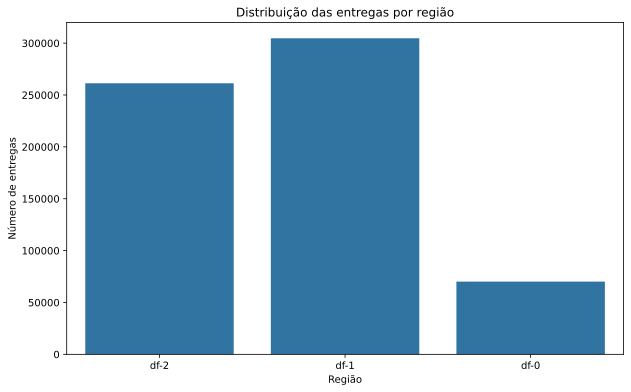

In [30]:
# Visualização 1: Gráfico de barras das regiões de entrega
plt.figure(figsize=(10, 6))
sns.countplot(data=deliveries_df, x='region')
plt.title('Distribuição das entregas por região')
plt.xlabel('Região')
plt.ylabel('Número de entregas')
plt.show()

2. Impacto da localização dos hubs:

Os hubs das regiões 0 e 2 estão localizados em áreas mais afastadas do centro e entre si, o que pode resultar em tempos e custos de entrega mais elevados.
Essa informação pode ser utilizada para otimizar a localização dos hubs, a fim de reduzir distâncias e melhorar a eficiência das entregas.

In [31]:
# Visualização 2: Gráfico de dispersão das coordenadas de entrega
plt.figure(figsize=(10, 6))
plt.scatter(deliveries_df['delivery_lng'], deliveries_df['delivery_lat'], color='blue', alpha=0.5)
plt.title('Distribuição geográfica das entregas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

3. Capacidade dos veículos por região:

A região 1 possui veículos com capacidade significativamente maior em comparação com as outras regiões.
Isso pode indicar uma demanda maior de transporte de carga ou a necessidade de lidar com produtos volumosos ou pesados nessa região específica.
Essa informação é relevante para o planejamento da frota de entrega e alocação de recursos adequados em cada região.

In [ ]:
# Visualização 3: Gráfico de barras da capacidade dos veículos por região
plt.figure(figsize=(10, 6))
sns.barplot(data=deliveries_df, x='region', y='vehicle_capacity')
plt.title('Capacidade dos veículos por região')
plt.xlabel('Região')
plt.ylabel('Capacidade dos veículos')
plt.show()

4. Distribuição das Entregas por Tamanho

A partir da análise do gráfico de barras, podemos observar a distribuição das entregas por tamanho. A maioria das entregas possui tamanhos pequenos e médios, enquanto as entregas de grande porte são menos frequentes. Isso pode indicar que a demanda por entregas menores é maior ou que a capacidade dos veículos de entrega é limitada para grandes cargas.

Essa informação é relevante para a tomada de decisões estratégicas relacionadas ao planejamento e alocação de recursos. Compreender a distribuição das entregas por tamanho permite otimizar o dimensionamento da frota de veículos, garantindo que haja capacidade suficiente para atender à demanda predominante de tamanhos menores, ao mesmo tempo em que se considera a capacidade limitada para entregas de grande porte.

Com base nesse insight, a empresa pode ajustar sua logística e estratégias de transporte, considerando as demandas específicas de cada tamanho de entrega. Isso pode resultar em melhorias na eficiência operacional, redução de custos e maior satisfação do cliente.

In [ ]:
# Visualização 4: Distribuição das entregas por tamanho

delivery_size_counts = deliveries_df['delivery_size'].value_counts()

delivery_sizes = sorted(delivery_size_counts.index)

plt.figure(figsize=(10, 6))
sns.barplot(x=delivery_sizes, y=delivery_size_counts)
plt.xlabel('Tamanho de Entrega')
plt.ylabel('Quantidade de Entregas')
plt.title('Distribuição das Entregas por Tamanho de Entrega')
plt.xticks(rotation=45)
plt.show()

5. Distribuição da Capacidade dos Veículos por Região

Uma análise importante no contexto logístico é entender a capacidade dos veículos de entrega em cada região. Isso pode influenciar a eficiência e a quantidade de entregas realizadas em determinadas áreas. Vamos explorar essa informação por meio de um histograma que mostra a distribuição das capacidades dos veículos em cada região.

Ao observar o histograma, podemos notar que a maioria das regiões apresenta uma distribuição semelhante, com uma concentração maior de veículos de capacidade média. No entanto, a região df-1 se destaca com uma proporção maior de veículos de alta capacidade em comparação com as outras regiões.

Isso pode indicar que a região df-1 lida com volumes de entrega maiores ou atende áreas com uma demanda logística mais complexa. Por outro lado, as regiões df-0 e df-2 possuem uma proporção ligeiramente maior de veículos de baixa capacidade em relação às outras regiões.

Essa análise sugere a possibilidade de ajustar a alocação de recursos logísticos, como a realocação de veículos de alta capacidade da região df-1 para as regiões df-0 e df-2, a fim de otimizar as operações de entrega nessas áreas. Com uma distribuição mais equilibrada de capacidades de veículos, é possível melhorar a eficiência e reduzir o tempo e os custos de entrega em regiões com menor capacidade de transporte.

Essa visualização nos permite entender as diferenças nas capacidades dos veículos em cada região e pode servir como base para tomadas de decisões estratégicas no planejamento logístico.

In [ ]:
# Visualização 5: Distribuição da Capacidade dos Veículos por Região

plt.figure(figsize=(10, 6))
sns.histplot(data=deliveries_df, x='vehicle_capacity', hue='region', bins=10, multiple='stack', palette='viridis')
plt.xlabel('Capacidade do Veículo')
plt.ylabel('Contagem')
plt.title('Distribuição da Capacidade dos Veículos por Região')
plt.legend(title='Região')
plt.show()


Esses insights nos ajudam a compreender melhor o panorama das entregas por região, destacando diferenças importantes que podem influenciar na estratégia logística e no desempenho do serviço de entrega.

In [37]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Análise Exploratória de Dados de Logística.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.



ValueError: file 'Análise Exploratória de Dados de Logística.ipynb' not found in path '/content/drive/MyDrive/Colab Notebooks/'.